# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import re
import matplotlib.pyplot as plt
import warnings
import string
warnings.filterwarnings("ignore", category=FutureWarning)
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Import The Dataset

The data processed contains the the training data, validation data, and test data (with unmasked and masked label) that has been preprocessed. However, later on, we will further preprocess the code to increase the accuracy.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_csv("drive/MyDrive/sentiment-prosa/train_preprocess.tsv", sep='\t', header=None)
df_valid = pd.read_csv("drive/MyDrive/sentiment-prosa/valid_preprocess.tsv", sep='\t', header=None)
df_test_unmasked = pd.read_csv("drive/MyDrive/sentiment-prosa/test_preprocess.tsv", sep='\t', header=None)
df_test_masked = pd.read_csv("drive/MyDrive/sentiment-prosa/test_preprocess_masked_label.tsv", sep='\t', header=None)

Open the vocabulary document

In [ ]:
with open('drive/MyDrive/sentiment-prosa/vocab_uncased.txt', 'r') as f:
    vocab = f.read().splitlines()

In [ ]:
df_train.columns = ["text", "emotion"]
df_valid.columns = ["text", "emotion"]
df_test_unmasked.columns = ["text", "emotion"]
df_test_masked.columns = ["text", "emotion"]

df_train.head(10)

,text,emotion
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
5,"makanan beragam , harga makanan di food stall ...",positive
6,pakai kartu kredit bca tidak untung malah rugi...,negative
7,"tempat unik , bagus buat foto , makanan enak ,...",positive
8,saya bersama keluarga baru saja menikmati peng...,positive
9,bersyukur,positive


# Pre-processing

## Remove punctuation and numbers

In [ ]:
def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', text)

In [ ]:
df_train['text'] = df_train['text'].apply(remove_punctuation)
df_valid['text'] = df_valid['text'].apply(remove_punctuation)
df_test_unmasked['text'] = df_test_unmasked['text'].apply(remove_punctuation)
df_test_masked['text'] = df_test_masked['text'].apply(remove_punctuation)

vocab_filtered = []

for word in vocab:
  word_filtered = remove_punctuation(word)
  vocab_filtered.append(word_filtered)



## Stop words removal and tokenization

In [ ]:
# Set stopwords
stop_words = set(stopwords.words('indonesian'))

def tokenize_text(text):
    tokens = word_tokenize(text)
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply tokenization to the train, validation, and test datasets
df_train['text'] = df_train['text'].apply(tokenize_text)
df_valid['text'] = df_valid['text'].apply(tokenize_text)
df_test_unmasked['text'] = df_test_unmasked['text'].apply(tokenize_text)

In [ ]:
df_train.head(10)

,text,emotion
0,warung dimiliki pengusaha pabrik puluhan terke...,positive
1,mohon ulama lurus k mmbri hujjah partai diwlh ...,neutral
2,lokasi strategis jalan sumatera bandung nya ny...,positive
3,betapa bahagia nya unboxing paket barang nya b...,positive
4,duh mahasiswa sombong kasih kartu kuning belaj...,negative
5,makanan beragam harga makanan food stall kasir...,positive
6,pakai kartu kredit bca untung rugi,negative
7,unik bagus foto makanan enak pegawai ramah ber...,positive
8,keluarga menikmati pengalaman kuliner menyenan...,positive
9,bersyukur,positive


In [ ]:
df_test_unmasked.head(10)

,text,emotion
0,kemarin gue makan dago gue makanan nya enak ha...,negative
1,kayak nya sih gue gila ya gue ngerti nya dibia...,negative
2,dipikir pikir dibanggakan jokowi nepatin janji...,negative
3,kalinya gua bank ngurusin pembuatan rekening n...,negative
4,gue disuruh latihan karate nya biar gue melawa...,negative
5,pelayanan hotel salak bogor sebagus gue membay...,negative
6,young lex mengirim berfaedah kayak gitu merusa...,negative
7,gue pesimis manusia ngurusin sampah hewan hewa...,negative
8,kecewa pengeditan biodata penumpang by sistem ...,negative
9,pemesanan tiket kunjung terima menelpon pelaya...,negative


# Exploratory Data Analysis

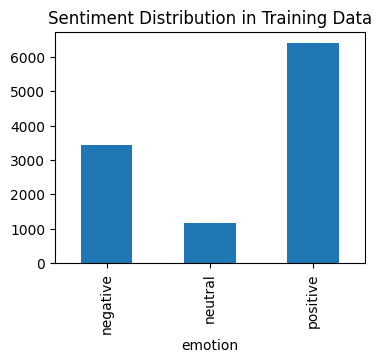

,text
emotion,
negative,3436
neutral,1148
positive,6416


In [ ]:
fig = plt.figure(figsize=(4,3))
df_train.groupby('emotion').text.count().plot.bar(ylim=0)
plt.title("Sentiment Distribution in Training Data")
plt.show()
df_train.groupby('emotion').text.count()

In [ ]:
# Encoding emotions
emotion_encoding = {'negative': 0, 'neutral': 1, 'positive': 2}

df_train['emotion'] = df_train['emotion'].replace(emotion_encoding)
df_valid['emotion'] = df_valid['emotion'].replace(emotion_encoding)
df_test_unmasked['emotion'] = df_test_unmasked['emotion'].replace(emotion_encoding)
df_test_masked['emotion'] = df_test_masked['emotion'].replace(emotion_encoding)

# Experiment 1: Multinomial Naive Bayes

## Training

In [ ]:
# Create a bag of words from the vocab_uncased.txt
cleaned_vocab = [string.strip() for string in vocab_filtered if string.strip()]
cleaned_vocab = list(dict.fromkeys(cleaned_vocab))
vectorizer = CountVectorizer(vocabulary=cleaned_vocab)

# Extract training, validation, and test data into each array and transform using vocabulary
X_train = vectorizer.transform(df_train['text'])
y_train = df_train['emotion']
X_valid = vectorizer.transform(df_valid['text'])
y_valid = df_valid['emotion']
X_test = vectorizer.transform(df_test_unmasked['text'])
y_test = df_test_unmasked['emotion']

In [ ]:
# Create Naive Bayes model and train
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Validate on validation set
y_valid_pred = nb_model.predict(X_valid)

## Evaluate training model

In [ ]:
def class_report_valid(y_valid, y_valid_pred):
  # Evaluate using metrics
  accuracy = accuracy_score(y_valid, y_valid_pred)
  precision = precision_score(y_valid, y_valid_pred, average='macro')
  recall = recall_score(y_valid, y_valid_pred, average='macro')
  f1 = f1_score(y_valid, y_valid_pred, average='macro')

  print(f'Accuracy: {accuracy}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1-Score: {f1}')

  # Print classification report
  print(classification_report(y_valid, y_valid_pred, target_names=['negative', 'neutral', 'positive']))

def class_report_test(y_test, y_test_pred):
  accuracy_test = accuracy_score(y_test, y_test_pred)
  precision_test = precision_score(y_test, y_test_pred, average='macro')
  recall_test = recall_score(y_test, y_test_pred, average='macro')
  f1_test = f1_score(y_test, y_test_pred, average='macro')

  print(f'Test Accuracy: {accuracy_test}')
  print(f'Test Precision: {precision_test}')
  print(f'Test Recall: {recall_test}')
  print(f'Test F1-Score: {f1_test}')

In [ ]:
# Evaluate on validation set
class_report_valid(y_valid, y_valid_pred)

Accuracy: 0.8507936507936508
Precision: 0.8432896336015214
Recall: 0.7952589635588158
F1-Score: 0.8148173207036535
              precision    recall  f1-score   support

    negative       0.78      0.82      0.80       394
     neutral       0.86      0.66      0.75       131
    positive       0.89      0.90      0.89       735

    accuracy                           0.85      1260
   macro avg       0.84      0.80      0.81      1260
weighted avg       0.85      0.85      0.85      1260



In [ ]:
# Predict x column using NB model
y_test_pred = nb_model.predict(X_test)

# Evaluate on test set
class_report_test(y_test, y_test_pred)

# Error analysis: Print misclassified examples
df_test_unmasked['predicted_emotion'] = y_test_pred
misclassified = df_test_unmasked[df_test_unmasked['emotion'] != df_test_unmasked['predicted_emotion']]
misclassified_count = misclassified[['text', 'emotion', 'predicted_emotion']].shape[0]
print(f'Banyak data yang salah diprediksi: {misclassified_count}')

Test Accuracy: 0.654
Test Precision: 0.658025308025308
Test Recall: 0.5977221308103661
Test F1-Score: 0.598693640530925
Banyak data yang salah diprediksi: 173


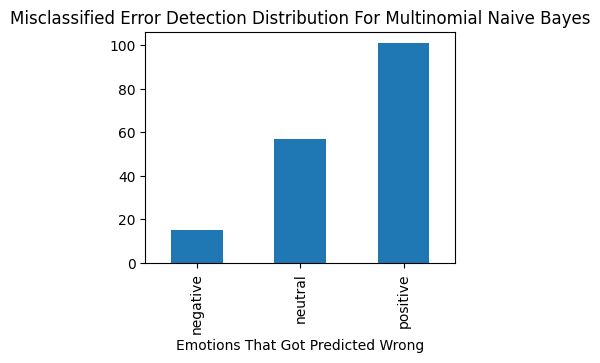

,text
emotion,
negative,15
neutral,57
positive,101


In [ ]:
misclassified_2 = misclassified.copy()

emotion_decoding = {0: 'negative', 1: 'neutral', 2: 'positive'}
misclassified_2['emotion'] = misclassified_2['emotion'].replace(emotion_decoding)
misclassified_2['predicted_emotion'] = misclassified_2['predicted_emotion'].replace(emotion_decoding)

fig = plt.figure(figsize=(4,3))
misclassified_2.groupby('emotion').text.count().plot.bar(ylim=0)
plt.title("Misclassified Error Detection Distribution For Multinomial Naive Bayes")
plt.xlabel('Emotions That Got Predicted Wrong')
plt.show()
misclassified_2.groupby('emotion').text.count()

# Experiment 2: Gaussian Naive Bayes

In [ ]:
# Create Naive Bayes model and train
nb_model = GaussianNB()
nb_model.fit(X_train.toarray(), y_train)

# Validate on validation set
y_valid_pred = nb_model.predict(X_valid.toarray())

## Evaluate training model

In [ ]:
def class_report_valid(y_valid, y_valid_pred):
  # Evaluate using metrics
  accuracy = accuracy_score(y_valid, y_valid_pred)
  precision = precision_score(y_valid, y_valid_pred, average='macro')
  recall = recall_score(y_valid, y_valid_pred, average='macro')
  f1 = f1_score(y_valid, y_valid_pred, average='macro')

  print(f'Accuracy: {accuracy}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1-Score: {f1}')

  # Print classification report
  print(classification_report(y_valid, y_valid_pred, target_names=['negative', 'neutral', 'positive']))

def class_report_test(y_test, y_test_pred):
  accuracy_test = accuracy_score(y_test, y_test_pred)
  precision_test = precision_score(y_test, y_test_pred, average='macro')
  recall_test = recall_score(y_test, y_test_pred, average='macro')
  f1_test = f1_score(y_test, y_test_pred, average='macro')

  print(f'Test Accuracy: {accuracy_test}')
  print(f'Test Precision: {precision_test}')
  print(f'Test Recall: {recall_test}')
  print(f'Test F1-Score: {f1_test}')

In [ ]:
# Evaluate on validation set
class_report_valid(y_valid, y_valid_pred)

Accuracy: 0.6523809523809524
Precision: 0.6028220488394066
Recall: 0.6268431537893312
F1-Score: 0.6040683559496611
              precision    recall  f1-score   support

    negative       0.52      0.72      0.60       394
     neutral       0.45      0.52      0.48       131
    positive       0.84      0.64      0.72       735

    accuracy                           0.65      1260
   macro avg       0.60      0.63      0.60      1260
weighted avg       0.70      0.65      0.66      1260



In [ ]:
# Predict x column using NB model
y_test_pred = nb_model.predict(X_test.toarray())

# Evaluate on test set
class_report_test(y_test, y_test_pred)

# Error analysis: Print misclassified examples
df_test_unmasked['predicted_emotion'] = y_test_pred
misclassified = df_test_unmasked[df_test_unmasked['emotion'] != df_test_unmasked['predicted_emotion']]
misclassified_count = misclassified[['text', 'emotion', 'predicted_emotion']].shape[0]
print(f'Banyak data yang salah diprediksi: {misclassified_count}')

Test Accuracy: 0.504
Test Precision: 0.46868695203713245
Test Recall: 0.46984265734265734
Test F1-Score: 0.45455877713942233
Banyak data yang salah diprediksi: 248


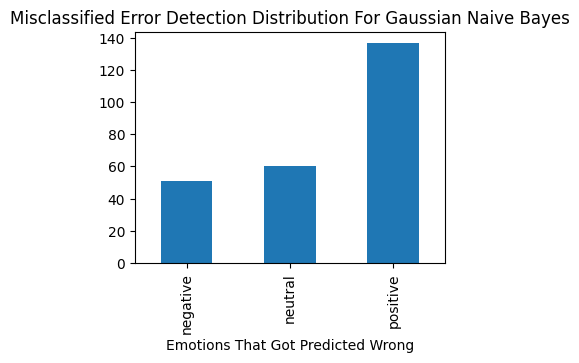

,text
emotion,
negative,51
neutral,60
positive,137


In [ ]:
misclassified_2 = misclassified.copy()

emotion_decoding = {0: 'negative', 1: 'neutral', 2: 'positive'}
misclassified_2['emotion'] = misclassified_2['emotion'].replace(emotion_decoding)
misclassified_2['predicted_emotion'] = misclassified_2['predicted_emotion'].replace(emotion_decoding)

fig = plt.figure(figsize=(4,3))
misclassified_2.groupby('emotion').text.count().plot.bar(ylim=0)
plt.title("Misclassified Error Detection Distribution For Gaussian Naive Bayes")
plt.xlabel('Emotions That Got Predicted Wrong')
plt.show()
misclassified_2.groupby('emotion').text.count()

# Experiment 3: Hyperparameter Tuning

In [ ]:
# Do hyperparameter tuning
parameters = {'alpha': [0.1, 0.5, 0.75, 1.0, 2.0]}
# Use grid search
grid_search = GridSearchCV(MultinomialNB(), parameters, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')

Best Parameters: {'alpha': 0.5}


## Training

In [ ]:
# Create Naive Bayes model and train
nb_model = MultinomialNB(alpha=0.5)
nb_model.fit(X_train, y_train)

# Validate on validation set
y_valid_pred = nb_model.predict(X_valid)

## Evaluate training model

In [ ]:
def class_report_valid(y_valid, y_valid_pred):
  # Evaluate using metrics
  accuracy = accuracy_score(y_valid, y_valid_pred)
  precision = precision_score(y_valid, y_valid_pred, average='macro')
  recall = recall_score(y_valid, y_valid_pred, average='macro')
  f1 = f1_score(y_valid, y_valid_pred, average='macro')

  print(f'Accuracy: {accuracy}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1-Score: {f1}')

  # Print classification report
  print(classification_report(y_valid, y_valid_pred, target_names=['negative', 'neutral', 'positive']))

def class_report_test(y_test, y_test_pred):
  accuracy_test = accuracy_score(y_test, y_test_pred)
  precision_test = precision_score(y_test, y_test_pred, average='macro')
  recall_test = recall_score(y_test, y_test_pred, average='macro')
  f1_test = f1_score(y_test, y_test_pred, average='macro')

  print(f'Test Accuracy: {accuracy_test}')
  print(f'Test Precision: {precision_test}')
  print(f'Test Recall: {recall_test}')
  print(f'Test F1-Score: {f1_test}')

In [ ]:
# Evaluate on validation set
class_report_valid(y_valid, y_valid_pred)

Accuracy: 0.8579365079365079
Precision: 0.8359110791129263
Recall: 0.8260028062839039
F1-Score: 0.8304621144300454
              precision    recall  f1-score   support

    negative       0.79      0.83      0.81       394
     neutral       0.81      0.76      0.78       131
    positive       0.90      0.89      0.90       735

    accuracy                           0.86      1260
   macro avg       0.84      0.83      0.83      1260
weighted avg       0.86      0.86      0.86      1260



In [ ]:
# Predict x column using NB model
y_test_pred = nb_model.predict(X_test)

# Evaluate on test set
class_report_test(y_test, y_test_pred)

# Error analysis: Print misclassified examples
df_test_unmasked['predicted_emotion'] = y_test_pred
misclassified = df_test_unmasked[df_test_unmasked['emotion'] != df_test_unmasked['predicted_emotion']]
misclassified_count = misclassified[['text', 'emotion', 'predicted_emotion']].shape[0]
print(f'Banyak data yang salah diprediksi: {misclassified_count}')

Test Accuracy: 0.638
Test Precision: 0.6467020743975266
Test Recall: 0.6088772338772339
Test F1-Score: 0.5990473181930085
Banyak data yang salah diprediksi: 181


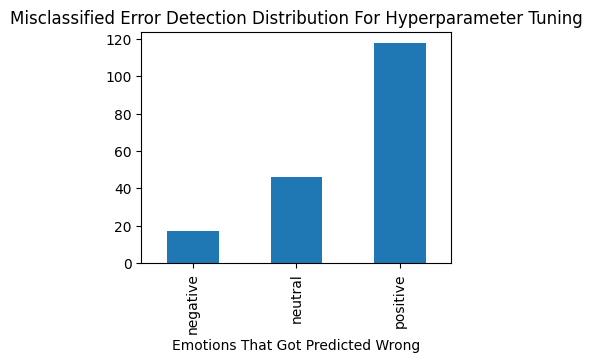

,text
emotion,
negative,17
neutral,46
positive,118


In [ ]:
misclassified_2 = misclassified.copy()

emotion_decoding = {0: 'negative', 1: 'neutral', 2: 'positive'}
misclassified_2['emotion'] = misclassified_2['emotion'].replace(emotion_decoding)
misclassified_2['predicted_emotion'] = misclassified_2['predicted_emotion'].replace(emotion_decoding)

fig = plt.figure(figsize=(4,3))
misclassified_2.groupby('emotion').text.count().plot.bar(ylim=0)
plt.title("Misclassified Error Detection Distribution For Hyperparameter Tuning")
plt.xlabel('Emotions That Got Predicted Wrong')
plt.show()
misclassified_2.groupby('emotion').text.count()